Objective:
Build a Machine Learning model to predict release cycle duration (in days) using historical release data.

This helps a Release Analyst / Project Manager estimate how long a new release will take based on parameters like:

Number of RFCs (change requests)

Number of test cases

Test pass rate

Sign-off time

IVB (Implementation Validation Build) scope

Release date

By predicting Cycle Time, organizations can:
✅ Plan releases more accurately
✅ Identify high-risk or delayed releases early
✅ Optimize resource allocation

In [1]:
# Import Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data

data = pd.read_csv("release_cycle_prediction_data.csv")

print("Dataset loaded successfully!")
print(data.head())

Dataset loaded successfully!
  Release_Date IVB_Scope  Number_of_RFCs  Number_of_Test_Cases  \
0   2022-01-01    Medium              28                   138   
1   2022-01-16     Major              56                   286   
2   2022-01-31    Medium              15                   422   
3   2022-02-15    Medium              53                   434   
4   2022-03-02     Minor              12                   321   

   Test_Pass_Rate  Sign_off_Time  Cycle_Time_days  
0       81.899548       4.574474        16.051126  
1       96.756907       1.943822        23.266874  
2       74.398145       7.636647        14.918885  
3       85.399785       2.640555        23.370579  
4       76.996842       6.075686        11.166249  


In [3]:
# Convert column to datetime and timedelta
# Convert Release_Date to datetime
data["Release_Date"] = pd.to_datetime(data["Release_Date"])
# Convert numeric day counts into timedelta (represents durations)
data["Sign_off_Time_Duration"] = pd.to_timedelta(data["Sign_off_Time"], unit='D')
data["Cycle_Time_Duration"] = pd.to_timedelta(data["Cycle_Time_days"], unit='D')

In [4]:
print(data.head())

  Release_Date IVB_Scope  Number_of_RFCs  Number_of_Test_Cases  \
0   2022-01-01    Medium              28                   138   
1   2022-01-16     Major              56                   286   
2   2022-01-31    Medium              15                   422   
3   2022-02-15    Medium              53                   434   
4   2022-03-02     Minor              12                   321   

   Test_Pass_Rate  Sign_off_Time  Cycle_Time_days    Sign_off_Time_Duration  \
0       81.899548       4.574474        16.051126 4 days 13:47:14.596155170   
1       96.756907       1.943822        23.266874 1 days 22:39:06.263895654   
2       74.398145       7.636647        14.918885 7 days 15:16:46.288258556   
3       85.399785       2.640555        23.370579 2 days 15:22:23.943902903   
4       76.996842       6.075686        11.166249 6 days 01:48:59.255553844   

         Cycle_Time_Duration  
0 16 days 01:13:37.270897334  
1 23 days 06:24:17.898444774  
2 14 days 22:03:11.690251439  
3 23

In [5]:
# Create a derived Release_End_Date (for illustration)
data["Release_End_Date"] = data["Release_Date"] + data["Cycle_Time_Duration"]

In [6]:
print("\n🕒 After converting to datetime formats:")
print(data[["Release_Date", "Sign_off_Time_Duration", "Cycle_Time_Duration", "Release_End_Date"]].head())


🕒 After converting to datetime formats:
  Release_Date    Sign_off_Time_Duration        Cycle_Time_Duration  \
0   2022-01-01 4 days 13:47:14.596155170 16 days 01:13:37.270897334   
1   2022-01-16 1 days 22:39:06.263895654 23 days 06:24:17.898444774   
2   2022-01-31 7 days 15:16:46.288258556 14 days 22:03:11.690251439   
3   2022-02-15 2 days 15:22:23.943902903 23 days 08:53:38.065344138   
4   2022-03-02 6 days 01:48:59.255553844 11 days 03:59:23.922597998   

               Release_End_Date  
0 2022-01-17 01:13:37.270897334  
1 2022-02-08 06:24:17.898444774  
2 2022-02-14 22:03:11.690251439  
3 2022-03-10 08:53:38.065344138  
4 2022-03-13 03:59:23.922597998  


In [7]:
# Preprocessing for ML
# Encode IVB_Scope (categorical → numeric)
le = LabelEncoder()
data["IVB_Scope_Encoded"] = le.fit_transform(data["IVB_Scope"])

In [8]:
# Use numeric versions (in days) for modeling
data["Sign_off_Days"] = data["Sign_off_Time_Duration"].dt.days + data["Sign_off_Time_Duration"].dt.seconds / 86400
data["Cycle_Time_Days"] = data["Cycle_Time_Duration"].dt.days + data["Cycle_Time_Duration"].dt.seconds / 86400

# Define features and target
X = data[["IVB_Scope_Encoded", "Number_of_RFCs", "Number_of_Test_Cases", "Test_Pass_Rate", "Sign_off_Days"]]
y = data["Cycle_Time_Days"]

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Train Models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

rf_reg = RandomForestRegressor(n_estimators=150, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [11]:
# Evaluation Function
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Model:")
    print(f" MAE: {mae:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" R²: {r2:.3f}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Linear Regression Model:
 MAE: 2.68
 RMSE: 3.18
 R²: 0.777

Random Forest Model:
 MAE: 3.49
 RMSE: 4.42
 R²: 0.566



In [12]:
# Cross-validation
cv_scores = cross_val_score(rf_reg, X, y, cv=5, scoring='r2')
print(f"Random Forest Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.3f}\n")

Random Forest Cross-Validation R² Scores: [0.49453266 0.70039485 0.65822474 0.57781138 0.69366311]
Mean CV Score: 0.625



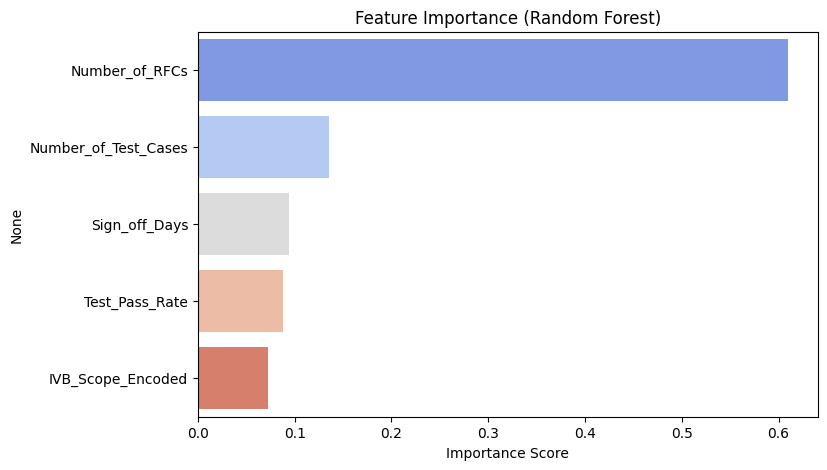

In [13]:
# Visualizations
plt.figure(figsize=(8,5))
importances = pd.Series(rf_reg.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, palette='coolwarm')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

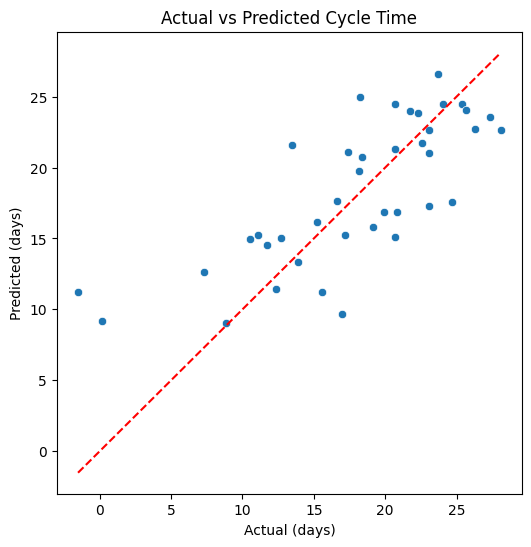

In [14]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Cycle Time")
plt.xlabel("Actual (days)")
plt.ylabel("Predicted (days)")
plt.show()

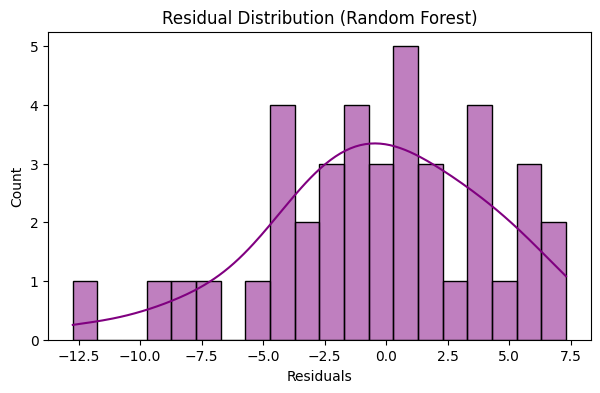

In [15]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=20, kde=True, color='purple')
plt.title("Residual Distribution (Random Forest)")
plt.xlabel("Residuals")
plt.show()